# Practical Exercise: Data Preparation and Visualisation

## Exercise I. Data Loading and Preparation

In [1]:
import pandas as pd
import numpy as np
import h5py
import os, glob
import re
from datetime import datetime, date, time
from six import iteritems
%load_ext autoreload
%autoreload 2

###  1. Data Reading and Exploration

### Initialize Class and Read files
In blond.py file, you can find the Blond class which handles data input, output and calibration. When the Blond class is initiated, it tries to acquire the data, whose interval is specified as an input. 

**Note that:** 
* Your data should be under **./data/** folder. For example **./data/clear** and **./data/medal-2**. 

* It only reads h5py file names and extracts the structure of the data, i.e. number of medals and signal names under each device, which is not actually reading the data. 

* From this point on, using this Blond object one can not read any other time which is not in the interval of the data itself. For example, your latest clear hdf5 file is 02:15:20, when you ask for clear data between 02:20:25-02:20:30 you wont get any data. But you are still able to get data for 02:18:10-02:20:20, since clear data contains 5 minutes of data in a file.

In [2]:
from blond import Blond,get_time_diff
blond = Blond(date(2016,10,5))

Checking the retrieved files

In [3]:
blond.list_files()

{'clear': ['clear-2016-10-05T00-01-50.891503T+0200-0001306.hdf5',
  'clear-2016-10-05T00-06-51.177842T+0200-0001307.hdf5',
  'clear-2016-10-05T00-11-51.464126T+0200-0001308.hdf5',
  'clear-2016-10-05T00-16-51.750433T+0200-0001309.hdf5',
  'clear-2016-10-05T00-21-52.035992T+0200-0001310.hdf5',
  'clear-2016-10-05T00-26-52.322393T+0200-0001311.hdf5',
  'clear-2016-10-05T00-31-52.608751T+0200-0001312.hdf5',
  'clear-2016-10-05T00-36-52.894519T+0200-0001313.hdf5',
  'clear-2016-10-05T00-41-53.180820T+0200-0001314.hdf5',
  'clear-2016-10-05T00-46-53.467073T+0200-0001315.hdf5',
  'clear-2016-10-05T00-51-53.752681T+0200-0001316.hdf5',
  'clear-2016-10-05T00-56-54.039123T+0200-0001317.hdf5',
  'clear-2016-10-05T01-01-54.325533T+0200-0001318.hdf5',
  'clear-2016-10-05T01-06-54.611818T+0200-0001319.hdf5',
  'clear-2016-10-05T01-11-54.897536T+0200-0001320.hdf5',
  'clear-2016-10-05T01-16-55.183843T+0200-0001321.hdf5',
  'clear-2016-10-05T01-21-55.470225T+0200-0001322.hdf5',
  'clear-2016-10-05T01

Checking the data structure

See the possible time ranges for each device. Note that, all the times are inclusive. If you see a time of *medal-1* for *latest* *2:17:12* , you will get the data until the end of 12.th second.

In [4]:
blond.time_limits

{'clear': {'earliest': datetime.time(0, 1, 50),
  'latest': datetime.time(12, 7, 31)},
 'medal-1': {'earliest': datetime.time(0, 2, 13),
  'latest': datetime.time(3, 47, 13)},
 'medal-2': {'earliest': datetime.time(0, 2, 17),
  'latest': datetime.time(3, 47, 16)},
 'medal-3': {'earliest': datetime.time(0, 0, 9),
  'latest': datetime.time(23, 59, 59)}}

### Example Data Read

In order to read a data interval, one needs to specify **device**("clear", "medal-1"...), **signal**("current1", "current2"...), start and end times. The time parameters here should be present in the specified device data. You can read either with or without calibration(actually "calibration and centering" is one parameter, so if you calibrate it is also centered). 

**Note:** While start time(start_ts) is inclusive, end time(end_ts) is exclusive. So for the example below, you will get the data of whole 0:50:0, so 0:50:1 is not included.

In [5]:
the_data = blond.read_data(
    device="medal-1",
    signal="current1",
    start_ts=time(0,50,0), 
    end_ts=time(0,50,1),
    calibrate=False
)
the_data.shape

(6400,)

### Exploration


Signals acquisited by MEDAL

In [6]:
blond.get_data_structure()["medal-1"]

['current1',
 'current2',
 'current3',
 'current4',
 'current5',
 'current6',
 'voltage']

Signals acquisited by CLEAR

In [7]:
blond.get_data_structure()["clear"]

['current1', 'current2', 'current3', 'voltage1', 'voltage2', 'voltage3']

### Centering and calibrating

When *read_data* function of the Blond class is called, the data is calibrated automatically. So we do not need an extra function call here.

**Note:** If you do not want the data centered and calibrated, you can call *read_data* with the **calibrate** = *False* parameter. Otherwise it will be always calibrated and centered.

## Exercise III. Feature Extraction

In order to run the Dash-Plotly application, you need to run **python app.py**. After the server runs, you can connect to the server and use the application.

## Exercise IV. Visualization

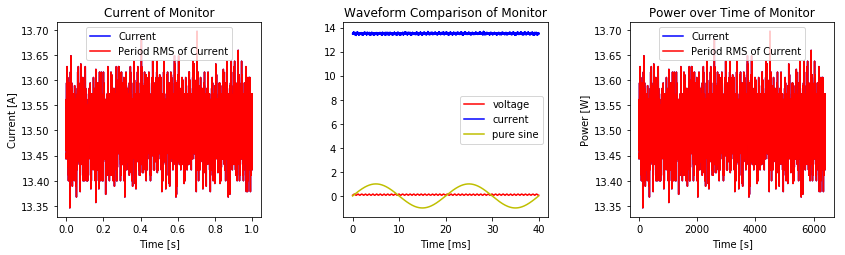

In [76]:
import numpy as np
import matplotlib.pyplot as plt

requested_time_start = time(0,0,9)
requested_time_end = time(0,0,10)

temp_data1 = blond.read_data(
    device="medal-3",
    signal="current5",
    start_ts=requested_time_start, 
    end_ts=requested_time_end,
)

temp_data2 = blond.read_data(
    device="medal-3",
    signal="voltage",
    start_ts=requested_time_start, 
    end_ts=requested_time_end,
)

#calculate period Root-Mean-Square of the Current
curr_rms = []
for curr in temp_data1:
    curr_rms.append(np.sqrt(np.mean(curr**2)))
    
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))


plot1 = ax[0]
t = np.arange(0.0, 1.0, 1/6400)
plot1.plot(t, temp_data1, color='b', label='Current')
plot1.plot(t, curr_rms, color='r', label='Period RMS of Current')
plot1.set_title('Current of Monitor')
plot1.set_xlabel('Time [s]')
plot1.set_ylabel('Current [A]')
plot1.legend()

plot2 = ax[1]
t = np.arange(0.0, 40, 40/6400)
sinewave = np.sin(2*np.pi*t/20)
plot2.plot(t, temp_data2/6400, color='r', label='voltage')
plot2.plot(t, curr_rms, color='b', label='current')
plot2.plot(t, sinewave, color='y', label='pure sine')
plot2.set_title('Waveform Comparison of Monitor')
plot2.set_xlabel('Time [ms]')
plot2.legend()

plot3 = ax[2]
plot3.plot(temp_data1, color='b', label='Current')
plot3.plot(curr_rms, color='r', label='Period RMS of Current')
plot3.set_title('Power over Time of Monitor')
plot3.set_xlabel('Time [s]')
plot3.set_ylabel('Power [W]')
plot3.legend()

plt.subplots_adjust(left=0, wspace=0.4, top=0.8)

plt.show()